In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt 

In [7]:
# Load data
df = pd.read_csv("pivoted_financial_data.csv")

# Create new features (example: growth rate for total income)
# Avoid division by zero
df["Income_Growth"] = np.where(df["Total income_1"] == 0, 0, 
                               (df["Total income_11"] - df["Total income_1"]) / df["Total income_1"])

df["Profit_Growth"] = np.where(df["Profit after tax_1"] == 0, 0, 
                               (df["Profit after tax_11"] - df["Profit after tax_1"]) / df["Profit after tax_1"])

# Select key features for feature vector (example selection, adjust as needed)
features = [
    "Total income_11", "Sales_11", "Net sales_11", "Profit after tax_11",
    "Sales / Net fixed assets_11", "Cash to current liabilities (times)_11", "Income_Growth", "Profit_Growth"
]
X = df[features]
y = df["Label"]

# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Build a pipeline: scaling -> SMOTE -> classifier (RandomForest example)
pipeline_rf = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__class_weight": [None, "balanced"]
}

def print_metrics(y_test,y_pred,clf):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='macro')
    recall = recall_score(y_test,y_pred, average='macro')
    f1 = f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

Best Params (RF): {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
For the Random Forest Classifier: 

Accuracy :  0.7970
Precision :  0.5190
Recall :  0.7123
F1 Score :  0.4849


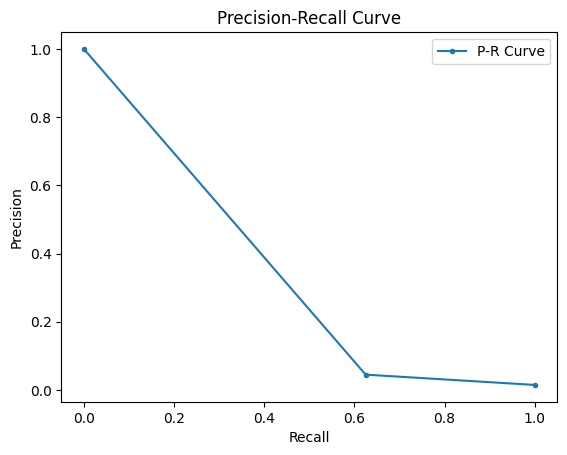

Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      1058
           1       0.05      0.62      0.08        16

    accuracy                           0.80      1074
   macro avg       0.52      0.71      0.48      1074
weighted avg       0.98      0.80      0.87      1074

Confusion Matrix:
 [[846 212]
 [  6  10]]
Best Params (SVM): {'classifier__C': 10, 'classifier__gamma': 0.1}
For the Random Forest Classifier: 

Accuracy :  0.7970
Precision :  0.5190
Recall :  0.7123
F1 Score :  0.4849


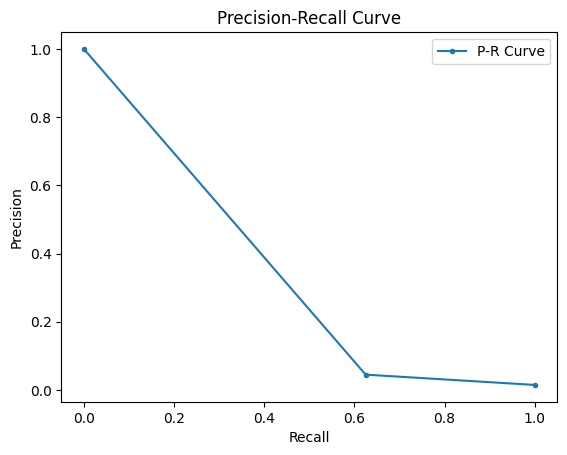

SVM Report:
               precision    recall  f1-score   support

           0       1.00      0.39      0.56      1058
           1       0.02      0.94      0.04        16

    accuracy                           0.40      1074
   macro avg       0.51      0.66      0.30      1074
weighted avg       0.98      0.40      0.56      1074

Confusion Matrix:
 [[415 643]
 [  1  15]]


In [9]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="f1", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best Params (RF):", grid_search_rf.best_params_)

# Evaluate on test set
y_pred_rf = grid_search_rf.predict(X_test)
print_metrics(y_test,y_pred_rf, "Random Forest")
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Repeat similar steps for SVM using SVC (with class_weight='balanced')
pipeline_svm = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

param_grid_svm = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": [0.001, 0.01, 0.1]
}

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="f1", n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
print("Best Params (SVM):", grid_search_svm.best_params_)

# Evaluate SVM
y_pred_svm = grid_search_svm.predict(X_test)
print_metrics(y_test,y_pred_rf, "Random Forest")
print("SVM Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))